# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate


### Files

#### Inputs

In [2]:
input_gisaid = 'data/raw/southamerica_metadata.xls'

#### Outputs



In [3]:
export_augur = 'data/clean/southamerica_metadata_clean.tsv'

### Parameters

## Load raw data from GISAID

In [4]:
meta_raw = pd.DataFrame(pd.read_excel(input_gisaid))
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_18698459,EPI2872452|A/Goose/Argentina/389-1/2023_PB2,EPI2872453|A/Goose/Argentina/389-1/2023_PB1,EPI2872451|A/Goose/Argentina/389-1/2023_PA,EPI2872455|A/Goose/Argentina/389-1/2023_HA,EPI2872448|A/Goose/Argentina/389-1/2023_NP,EPI2872454|A/Goose/Argentina/389-1/2023_NA,EPI2872450|A/Goose/Argentina/389-1/2023_MP,EPI2872449|A/Goose/Argentina/389-1/2023_NS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_17950994,NaN,NaN,NaN,EPI2610769|A/goose/Argentina/SENASA-140223/202...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_17885869,EPI2609130|A/goose/Araucania/239189-1/2023_PB2,EPI2609128|A/goose/Araucania/239189-1/2023_PB1,EPI2644589|A/goose/Araucania/239189-1/2023_PA,EPI2609126|A/goose/Araucania/239189-1/2023_HA,EPI2609127|A/goose/Araucania/239189-1/2023_NP,EPI2637161|A/goose/Araucania/239189-1/2023_NA,EPI2609131|A/goose/Araucania/239189-1/2023_MP,EPI2609129|A/goose/Araucania/239189-1/2023_NS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_17527083,NaN,NaN,NaN,EPI2528164|A/goose/Argentina/140223/2023,NaN,EPI2528165|A/goose/Argentina/140223/2023,NaN,NaN,NaN,...,NaN,NaN,NaN,OQ832505,NaN,OQ832506,NaN,NaN,NaN,NaN
4,EPI_ISL_18777130,EPI2921506|A/gull/Maule/SJCEIRR-2343291/2023,NaN,EPI2921502|A/gull/Maule/SJCEIRR-2343291/2023,EPI2921503|A/gull/Maule/SJCEIRR-2343291/2023,EPI2921504|A/gull/Maule/SJCEIRR-2343291/2023,EPI2921501|A/gull/Maule/SJCEIRR-2343291/2023,EPI2921507|A/gull/Maule/SJCEIRR-2343291/2023,EPI2921505|A/gull/Maule/SJCEIRR-2343291/2023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [5]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [6]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [7]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'avian_flu'

## Parse metadata

### Parse country

In [8]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

### Parse host

In [9]:
# Rename raw host column:
meta_working = meta_working.rename(
    columns = {
        'host': 'host_raw',
    }
)

# Empirical lists of avian and human values
hosts_avian = ['Chicken', 'Other avian', 'Avian',
               'Wild bird', 'Turkey', 'Duck',
               'Gull', 'Gallus gallus domesticus',
               'Goose', 'Penguin', 'Swan',
               'Anas platyrhynchos var. domesticus',
               'Anas cyanoptera', 'Rynchops niger',
               'Cormorant', 'Calidris alba',
               'Larosterna inca']
hosts_mammal = ['Other mammals', 'Feline']

def label_host(val):
    if val in hosts_avian:
        return 'Avian'
    elif val in hosts_mammal:
        return 'Mammal'
    elif val == 'Human':
        return 'Human'
    else:
        return np.nan

meta_working['host'] = (
    meta_working['host_raw']
    .apply(label_host))

In [10]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host_raw,submitting_lab,originating_lab,virus,region,country,host
0,A/Goose/Argentina/389-1/2023,2023-02-11,EPI_ISL_18698459,South America / Argentina / Provincia de Jujuy,Goose,Instituto Nacional de Enfermedades Infecciosas...,"Dirección del Laboratorio Animal, Dirección Ge...",avian_flu,South America,Argentina,Avian
1,A/goose/Argentina/SENASA-140223/2023,2023-02-11,EPI_ISL_17950994,South America / Argentina,Goose,NaN,NaN,avian_flu,South America,Argentina,Avian
2,A/goose/Araucania/239189-1/2023,2023-02-28,EPI_ISL_17885869,South America / Chile / Region de la Araucania,Goose,NaN,NaN,avian_flu,South America,Chile,Avian
3,A/goose/Argentina/140223/2023,2023-02-11,EPI_ISL_17527083,South America / Argentina,Goose,NaN,NaN,avian_flu,South America,Argentina,Avian
4,A/gull/Maule/SJCEIRR-2343291/2023,2023-01-26,EPI_ISL_18777130,South America / Chile / Region del Maule,Gull,Center of Excellence for Influenza Research an...,Center of Excellence for Influenza Research an...,avian_flu,South America,Chile,Avian
5,A/brown-hooded gull/Los Rios/SJCEIRR-2470941/2023,2023-04-04,EPI_ISL_18760072,South America / Chile / Region de Los Rios,Gull,Center of Excellence for Influenza Research an...,Center of Excellence for Influenza Research an...,avian_flu,South America,Chile,Avian
6,A/brown-hooded gull/Los Rios/SJCEIRR-2470931/2023,2023-04-04,EPI_ISL_18760071,South America / Chile / Region de Los Rios,Gull,Center of Excellence for Influenza Research an...,Center of Excellence for Influenza Research an...,avian_flu,South America,Chile,Avian
7,A/Belcher gull/Peru/UNMSM-A267/2022,2022-12,EPI_ISL_18371664,South America / Peru,Gull,NaN,NaN,avian_flu,South America,Peru,Avian
8,A/kelp gull/Maule/239349/2023,2023-03-01,EPI_ISL_17885972,South America / Chile / Region del Maule,Gull,NaN,NaN,avian_flu,South America,Chile,Avian
9,A/gray gull/Tarapaca/232825-1/2023,2023-01-18,EPI_ISL_17885951,South America / Chile / Region de Tarapaca,Gull,NaN,NaN,avian_flu,South America,Chile,Avian


## Clean dataframe
Clean up values.

Clean strain names.
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [11]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [12]:
meta_working.head(n=20)['strain']

0                          A/Goose/Argentina/389-1/2023
1                  A/goose/Argentina/SENASA-140223/2023
2                       A/goose/Araucania/239189-1/2023
3                         A/goose/Argentina/140223/2023
4                     A/gull/Maule/SJCEIRR-2343291/2023
5     A/brown-hooded_gull/Los_Rios/SJCEIRR-2470941/2023
6     A/brown-hooded_gull/Los_Rios/SJCEIRR-2470931/2023
7                   A/Belcher_gull/Peru/UNMSM-A267/2022
8                         A/kelp_gull/Maule/239349/2023
9                    A/gray_gull/Tarapaca/232825-1/2023
10                         A/gull/Peru/LIM-INS-006/2023
11                             A/Gull/Chile/7023-2/2022
12                             A/Gull/Chile/7023-3/2022
13                    A/black_skimmer/Chile/C61962/2022
14    A/black-necked_swan/Los_Rios/SJCEIRR-2472921/2023
15       A/black-necked_swan/Uruguay/UDELAR-014-M3/2023
16       A/black-necked_swan/Uruguay/UDELAR-078-M2/2023
17             A/turkey/Valparaiso/SJCEIRR-24556

### Deduplicate strains

In [13]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 258 records.
	There were 257 unique records.
	After cleaning, there were 257 records remaining.


### Clean up countries

In [14]:
meta_working['country'].value_counts(dropna=False)

country
Chile                                101
Peru                                  63
Argentina                             55
Uruguay                               12
Ecuador                                8
Brazil                                 7
Colombia                               6
Venezuela, Bolivarian Republic of      5
Name: count, dtype: int64

In [15]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {'Venezuela, Bolivarian Republic of': 'Venezuela'}
    ))

In [16]:
meta_working['country'].value_counts(dropna=False)

country
Chile        101
Peru          63
Argentina     55
Uruguay       12
Ecuador        8
Brazil         7
Colombia       6
Venezuela      5
Name: count, dtype: int64

### Clean up labs

In [17]:
meta_working['submitting_lab'] = (
    meta_working['submitting_lab']
    .replace(
        {'Instituto Nacional de Investigacion en Salud Publica (INSPI)': \
         'Instituto Nacional de Investigación en Salud Pública INSPI',
         'Instituto de Salud Publica': \
         'Instituto de Salud Publica de Chile'}
    ))

In [18]:
meta_working['originating_lab'] = (
    meta_working['originating_lab']
    .replace(
        {'Instituto Nacional de Investigacion en Salud Publica (INSPI)': \
         'Instituto Nacional de Investigación en Salud Pública INSPI',
         'INSPI': \
         'Instituto Nacional de Investigación en Salud Pública INSPI',}
    ))

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [19]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False)

## Plot and list all strains by country

### Plot strain counts by country

In [20]:
meta_clean['strain'].count()

257

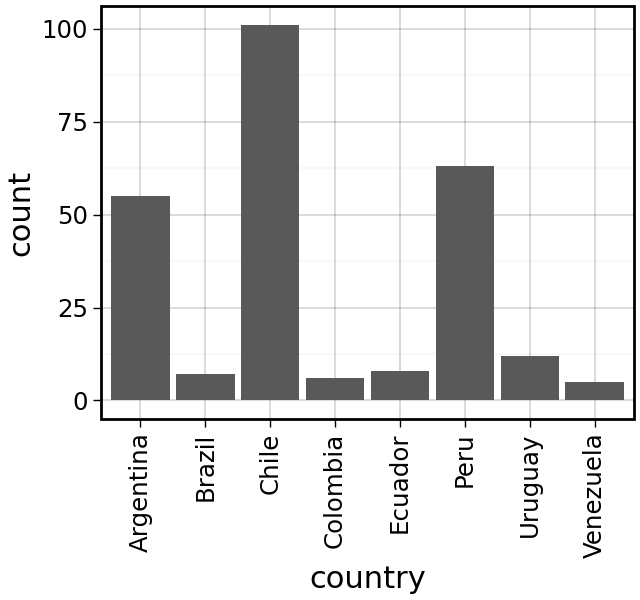

In [21]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(meta_clean['country'].nunique()/2.5,
                            3))
)

seqs_by_country

### List strains by country

In [22]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"\n# {key} (n={len(value)})")
    for v in value:
        print(v)


# Argentina (n=55)
A/Goose/Argentina/389-1/2023
A/goose/Argentina/SENASA-140223/2023
A/goose/Argentina/140223/2023
A/Turkey/Argentina/1711-2/2023
A/Turkey/Argentina/1710-1/2023
A/Turkey/Argentina/1348-3/2023
A/Turkey/Argentina/753-1/2023
A/Sea_Lion/Argentina/3893-1/2023
A/Sea_Lion/Argentina/3849-4/2023
A/Avian/Argentina/1790-5/2023
A/Avian/Argentina/1762-2/2023
A/Avian/Argentina/586-4/2023
A/Avian/Argentina/579-5/2023
A/Chicken/Argentina/2016-2/2023
A/Chicken/Argentina/895-1/2023
A/Chicken/Argentina/747-1/2023
A/Chicken/Argentina/1495-4/2023
A/Chicken/Argentina/3695-3/2023
A/Chicken/Argentina/3657-2/2023
A/Chicken/Argentina/3346-1/2023
A/Chicken/Argentina/2796-2/2023
A/Chicken/Argentina/2483-3/2023
A/Chicken/Argentina/2305-6/2023
A/Chicken/Argentina/2305-1/2023
A/Chicken/Argentina/2064-3/2023
A/Chicken/Argentina/2049-3/2023
A/Chicken/Argentina/2034-5/2023
A/Chicken/Argentina/1984-4/2023
A/Chicken/Argentina/1976-2/2023
A/Chicken/Argentina/1708-1/2023
A/Chicken/Argentina/1530-3/2023
A/C